In [69]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [70]:
from __future__ import print_function
import sys
%matplotlib inline
import pandas as pd
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas import Series, DataFrame
from time import time
sns.set()
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import r2_score, make_scorer, mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve

### Import the train and test data with no null values

In [71]:
train_df= pd.read_csv("house-prices/train_no_null.csv",index_col=[0])
test_df= pd.read_csv("house-prices/test_no_null.csv",index_col=[0])
train_df.shape,test_df.shape

((1460, 74), (1459, 73))

The test data does not have the Saleprice column. We have to predict the price.

In [72]:
set(train_df.columns ) - set(test_df.columns )

{'SalePrice'}

#### Correlation between SalePrice and other features

Text(0.5,1,'Correlation plot (train)')

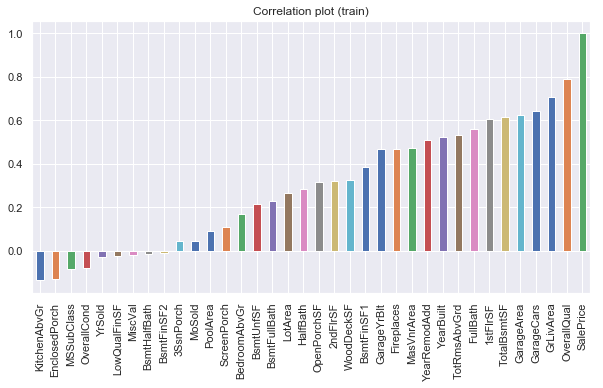

In [73]:
corr=train_df.corr()["SalePrice"]
plt.figure(figsize=(10,5))
corr.sort_values().plot.bar()
plt.title("Correlation plot (train)")

#### Correlation matrix for between features correlation

Text(0.5,1,'Correlation matrix (train)')

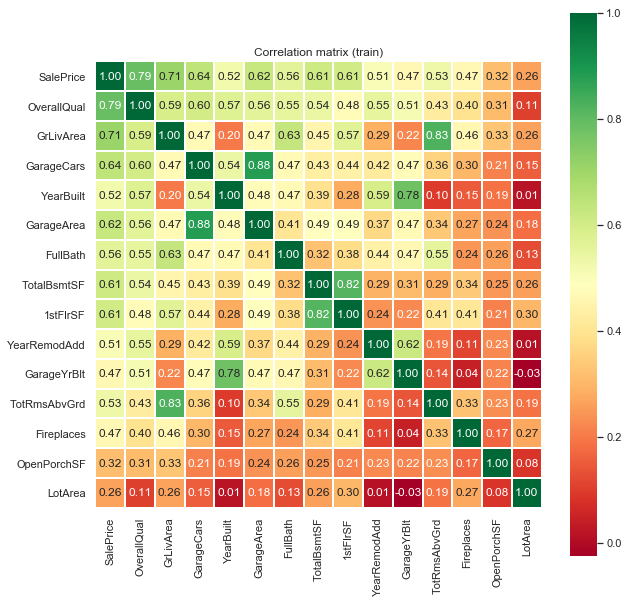

In [74]:
n_most_important=15 ## using only 15 highest correlated features with Saleprice
corr_mat = train_df.corr(method='spearman')
cols = corr_mat.abs().nlargest(n_most_important, "SalePrice")["SalePrice"].index
sns.set(font_scale=1.)
plt.figure(figsize=(10,10))
cor_map=sns.heatmap(np.corrcoef(train_df[cols].values.T),cmap="RdYlGn",\
                    linewidths=1., annot=True, square=True,\
                    vmax=1.,fmt='.2f',\
                    yticklabels=cols.values, xticklabels=cols.values)
plt.title("Correlation matrix (train)")

This is a symmetric matrix. We can just focus on upper/lower traingle.
The insights we get is that there  are pretty high correlations between some features (green boxes). Ex: GarageYrBlt and YearBlt, TotalBsmtSF and 1stFlrSF..

Text(0.5,1,'No of house sold yearwise')

<Figure size 360x360 with 0 Axes>

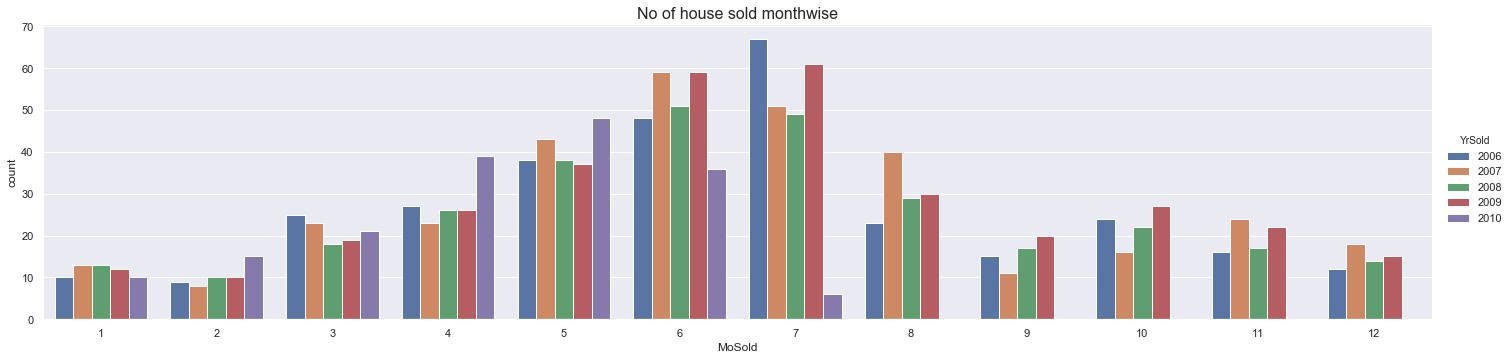

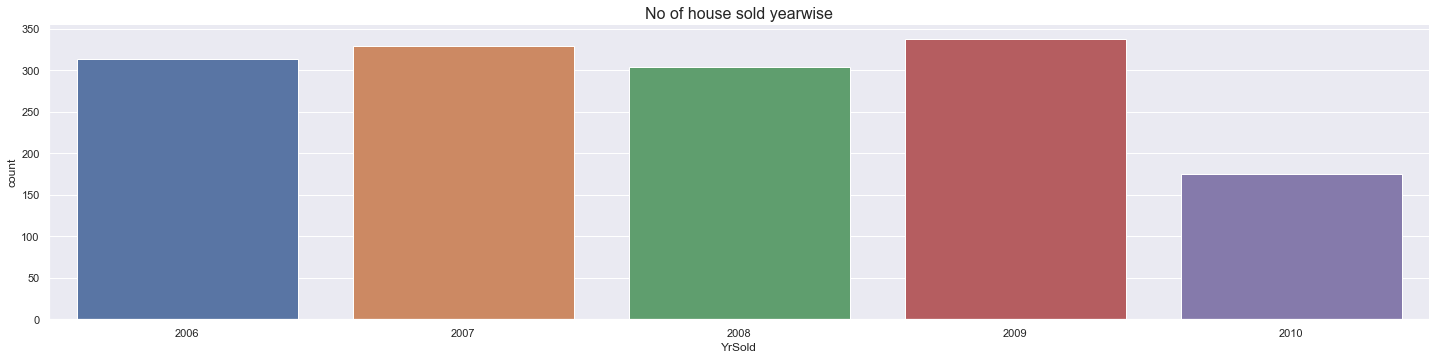

In [75]:
plt.figure(figsize=(5,5))
sns.catplot("MoSold", data=train_df, aspect=4.0, kind='count',
                       hue='YrSold')
plt.title("No of house sold monthwise",fontsize=16)
sns.catplot("YrSold", data=train_df, aspect=4.0, kind='count')
plt.title("No of house sold yearwise",fontsize=16)

From the above two plots we can infer that -
1. Most houses are sold during june, July
2. Least house sold on 2010, otherwise it is pretty uniform.

## Deal with numerical data 

#### 1. Pairplot of SalePrice vs numerical features in training data

In [76]:
num_train_df=train_df.select_dtypes(include=[np.int, np.float, np.bool])
## numeric train data (includes SalePrice)

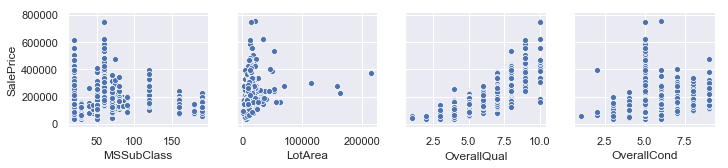

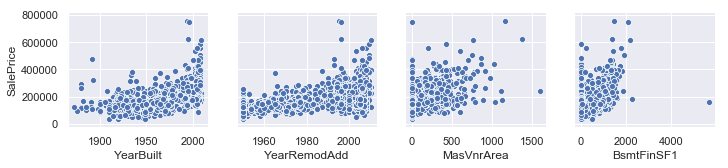

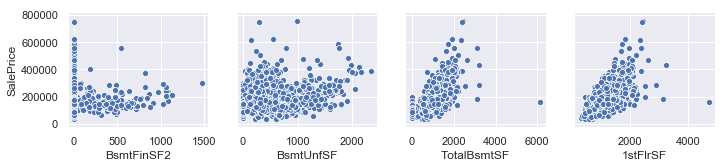

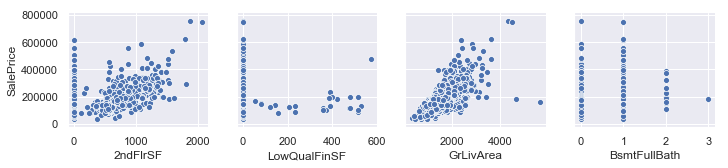

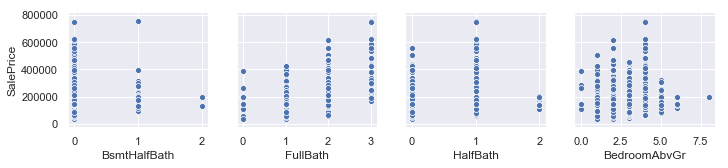

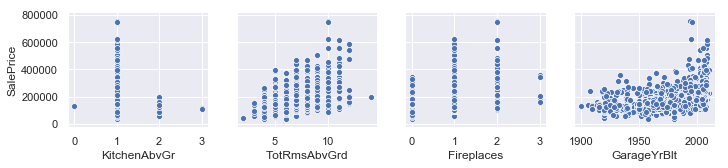

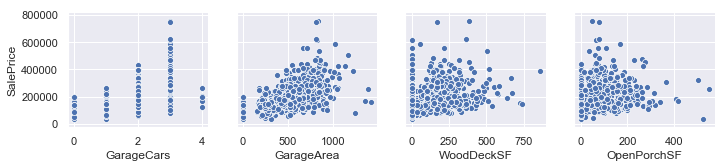

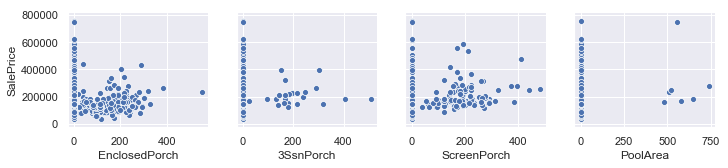

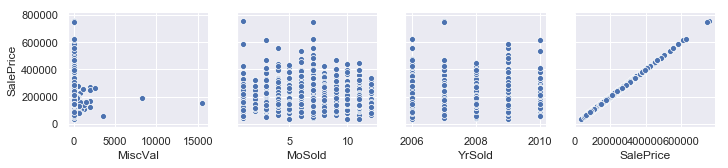

In [77]:
no_of_figs_row=4
for i in range(0, len(num_train_df.columns),no_of_figs_row):
    sns.pairplot(data=num_train_df,
                x_vars=num_train_df.columns[i:i+no_of_figs_row],markers="o",\
                y_vars='SalePrice',height=2.5,dropna=True,palette="Dark2")
    

We can see that-
There are many features which contain outlier. Therfore before fitting model we have to 
do feature scaling

In [25]:
num_train_df.shape ### shape of the train numeric data (includes SalePrice)

(1460, 36)

#### 2. Identify features which have outliers using inter quartile range

In [78]:
## https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/
import numpy as np

def outliers(data): ## this function will return data if it is out of bound
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((data > upper_bound) | (data < lower_bound))


no_out_list=["YearBuilt","YearRemodAdd","YrSold","MoSold"]
## we do not want to scale year, month 

outlier_index=[]
for column in num_train_df:
    if column not in no_out_list and column != "SalePrice" and \
             outliers(num_train_df[column].values) != 0:
        outlier_index.append(column)
print(outlier_index)

['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


#### 3. Feature scaling

In [79]:
new_train_df=train_df[[ind for ind in outlier_index]]
new_test_df=test_df[[ind for ind in outlier_index]]


selection = StandardScaler()
df_train_scaled = selection.fit_transform(new_train_df) ## fit and transform to train data
df_test_scaled = selection.transform(new_test_df) ## only transform test data
#pd.DataFrame(df_train_scaled,columns=outlier_index).head()

updated_numeric_traindf=pd.concat([train_df[[n for n in no_out_list]], \
           pd.DataFrame(df_train_scaled,columns=outlier_index)], axis=1)
updated_numeric_testdf=pd.concat([test_df[[n for n in no_out_list]], \
           pd.DataFrame(df_test_scaled,columns=outlier_index)], axis=1)
updated_numeric_traindf.shape, updated_numeric_testdf.shape
## we have not touche dthe saleprice column in train_df

((1460, 35), (1459, 35))

## Deal with categorical data

In [80]:
categorical_train_frame=train_df.select_dtypes(exclude=[np.int, np.float, np.bool])

#### plot distribution of different categorical features

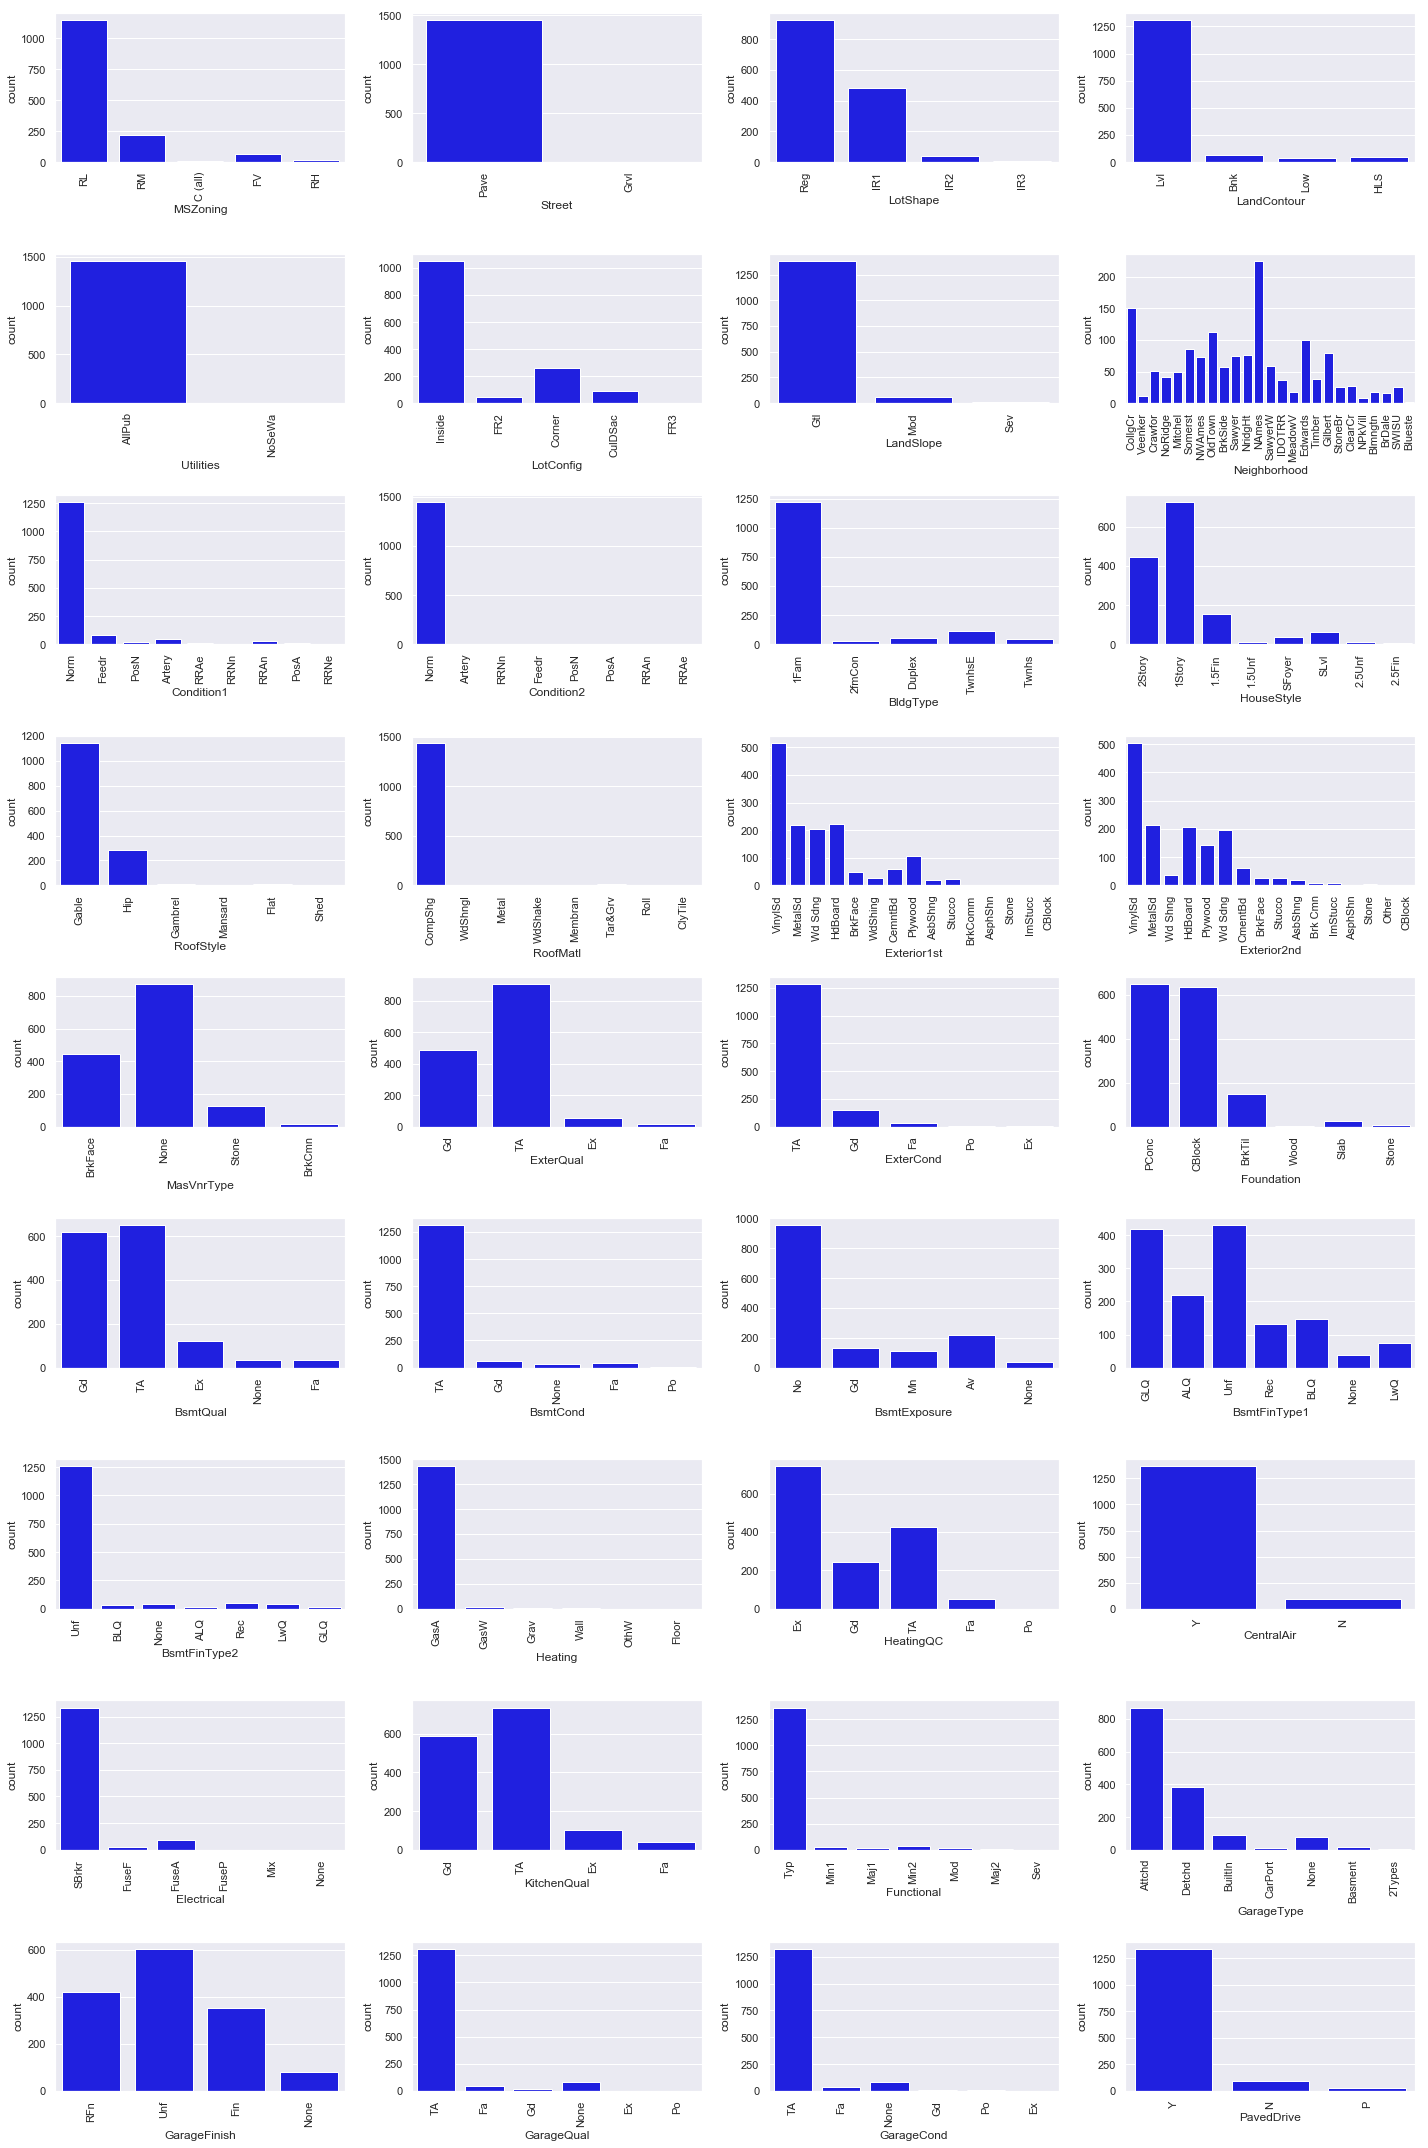

In [81]:
rows=int(len(categorical_train_frame.columns)/4.)
col=4
fig, axes = plt.subplots(rows,col, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
    sns.countplot(x=categorical_train_frame.columns[i], y=None, \
                  data=categorical_train_frame, ax=ax,color="Blue")
fig.tight_layout()

We see that-
1. There are many features where only one category dominates. Ex: GarageCond, PavedDrive
Those are irrelevant features as most of the houses have the dominant category, so they will
not imapact Saleprice much. We can drop those features.

2. There are certain neighborhoods where more houses are sold than others.

#### Remove dominat category feature

In [82]:
def nonmajor_cat(df,count_no): ## this function will list the columns with dominant category
    nonmajor_cat_col=[]
    for col in df.columns:
        labels=df[col].astype('category').cat.categories.tolist()
        counts = df[col].value_counts()
        label_count=np.array([counts[var_cat] for var_cat in labels])
        if any(i>count_no for i in label_count):
           nonmajor_cat_col.append(col)
    return nonmajor_cat_col

## We have total 1460 data. I am using 1300 as cut off for dominant category.
dropped_col=nonmajor_cat(categorical_train_frame,1300) 

######## drop cols from train data
categorical_train_frame.drop(dropped_col,axis=1,inplace=True)

######## drop cols from test data
categorical_test_frame=test_df.select_dtypes(exclude=[np.int, np.float, np.bool])
categorical_test_frame.drop(dropped_col,axis=1,inplace=True)


##########shape of the categorical data frame for train and test
categorical_train_frame.shape, categorical_test_frame.shape

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


((1460, 24), (1459, 24))

In [83]:
final_train_df=pd.concat([updated_numeric_traindf,categorical_train_frame],axis=1)
final_test_df=pd.concat([updated_numeric_testdf,categorical_test_frame],axis=1)
final_train_df.shape,final_test_df.shape

((1460, 59), (1459, 59))

We will use pd.get_dummies for tarnsforming categorical data to one-hot-encoded format.
That is why we need to combine train and test data, so that both traina nd test data has same features

In [84]:
final_train_df['dummy'] = True ## for one hot encoding we need to combine train
final_test_df['dummy'] = False
train_test_df = pd.concat([final_train_df,final_test_df])

train_test_df_new=pd.get_dummies(train_test_df)

X_train = train_test_df_new[train_test_df_new['dummy']==True]
X_train = X_train.drop('dummy', axis=1)
X_test = train_test_df_new[train_test_df_new['dummy']==False]
X_test = X_test.drop('dummy', axis=1)
X_train.shape, X_test.shape

((1460, 216), (1459, 216))

### Lets inspect the target column "Saleprice"

In [85]:
print("new skewness",train_df['SalePrice'].skew())

new skewness 1.8828757597682129


#### Adjust skewness

mean: 180921.19589041095 sigma: 79415.29188606751
old skewness 1.8828757597682129
new skewness: 0.12133506220520406


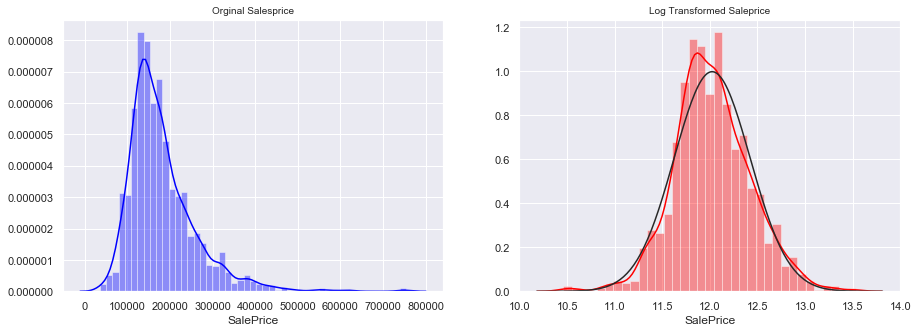

In [86]:
log_saleprice=np.log(train_df['SalePrice'])

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1 = sns.distplot(train_df['SalePrice'], color="Blue", ax=ax1)
ax1.set_title("Orginal Salesprice", fontsize=10)

ax2 = sns.distplot(log_saleprice, color="red",ax=ax2, fit=norm)
ax2.set_title("Log Transformed Saleprice", fontsize=10)

mu, sigma = norm.fit(train_df['SalePrice'])
print("mean:",mu,"sigma:",sigma)
print("old skewness",train_df['SalePrice'].skew())
print("new skewness:",log_saleprice.skew())
plt.show()

In [87]:
y_train=np.array(log_saleprice)

Now we are ready to fit the training set.

In [88]:
%store X_train
%store y_train
%store X_test

Stored 'X_train' (DataFrame)
Stored 'y_train' (ndarray)
Stored 'X_test' (DataFrame)
